# Adaptive rejection sampling

Rejection sampling (RS) is a useful method for sampling intractable distributions. It defines an envelope function which upper-bounds the target unnormalised probability density to be sampled. It then proceeds to sample points in the area under the envelope, rejecting those points which fall above the target and accepting the rest. The accepted points are independent and identically distributed samples from the target distribution. There are two important issues with RS. The first is that if the envelope is a very loose upper bound, then most samples will be rejected and the scheme will be slow. The second is that for rejection sampling to work, we must be certain that the envelope is an upper bound to the target, which in practice may be a challenging task.

Adaptive rejection sampling (ARS) {cite}`gilks1992ars` is an efficient method for sampling log-concave targets, which deals with both of these issues. It is origially defined for univariate distributions, but can also be extended to multivariate distributions via Gibbs sampling.{cite}`bishop2006PRML` ARS maintains an envelope which adapts as more points are sampled, becoming a progressively tighter bound to the target, thereby avoiding the inefficiency of regular RS. Further, the way that ARS constructs this envelope guarantees that the envelope is in fact an upper bound to the target, which sidesteps the second difficulty described above.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML, set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

## An adaptive envelope function

Suppose we wish to sample from a log-concave univariate distribution with unnormalised distribution function $f$. Whereas RS defines a fixed envelope, ARS will define an envelope $g_u$ that upper bounds $f$ and adapts its shape as the sampling procedure progresses. By adapting its shape, using the infromation that $f$ is log-concave, the envelope reduces the probability of future rejections. In addition the envelope function, ARS can use an optional function $g_l$ which lower bounds $f$, called the squeezing function. The squeezing function can be used to avoid evaluating $f$ in the rejection step, which can be especially useful if $f$ is computationally expensive to evaluate.

Given the an ordered set of points $x_1 < x_2 < ... < x_K$, ARS defines the log-envelope $\log ~ g_u$ to be the minimum over the tangents to $h = \log f$ at these points. The log-squeezing function is defined to be the piecewise linear function which joins the points $(x_k, h(x_k))$ inside the interval $[x_1, x_K]$ and is equal to $-\infty$ outside this innterval. Examples of envelope and squeezing functions are shown below.

<div class="definition">
    
**Definition (Abscissa set, envelope function and squeezing function)** Let $f(x)$ be a univariate log-concave function, with non-zero domain $D = \{x : f(x) > 0\}$. An abscissa set $T_K$ is an ordered set of points in $D$ such that
    
$$T_k = \{x_1 < x_2 < ... < x_K\}.$$
    
The envelope function $g_u(x)$ defined by $T_k$ is
    
$$g_u(x) = \min_{k} g_{u, k}(x)$$
    
where $g_{u, k}(x), k = 1, 2, ..., K$ are piecewise exponential functions such that
    
$$g_{u, k}(x_k) = f(x_k) \text{ and } g_{u, k}'(x_k) = \log f'(x_k).$$
    
The squeezing function $g_l(x)$ defined by $T_k$ is
    
$$g_l(x) = \begin{cases} \min_{k} g_{l, k}(x)  & \text{ if } x_1 \leq x \leq x_k, \\ 0 & \text{ otherwise.} \end{cases}$$
    
where $g_{u, k}(x), k = 1, 2, ..., K - 1$ are piecewise exponential functions such that
    
$$g_{l, k}(x_k) = f(x_k) \text{ and } g_{l, k}(x_{k+1}) = \log f(x_{k+1}).$$
    
</div>
<br>

Below are functions implementing the necessary calculations to determine the envelope and squeezing functions, all of which are cheap operations. The functions take in points at input locations $x$ and corresponding $h$ and $h'$ values and carry out computations in log-space, before exponentiating the result at the end.

In [142]:
def g_u(x, xs, hs, dhdxs):
    
    z, _ = compute_intercepts_and_points_of_intersection(xs, hs, dhdxs)
    i = np.searchsorted(z, x)
    
    return np.exp(dhdxs[i] * (x - xs[i]) + hs[i])
    

def g_l(x, xs, hs):
    
    if all(x < xs) or all(x > xs):
        return 0.
    
    else:
        i = np.searchsorted(xs, x)
        m = (hs[i] - hs[i-1]) / (xs[i] - xs[i-1])
        
        return np.exp(hs[i-1] + (x - xs[i-1]) * m)


def compute_intercepts_and_points_of_intersection(x, h, dhdx):
    
    # y-intercepts c of envelope function line segments, intersection points z
    c = h - dhdx * x
    z = (c[1:] - c[:-1]) / (dhdx[:-1] - dhdx[1:])
    
    return z, c

Now let's define a log unnormalised Gaussian log density, and use this to illustrate the envelope and squeezing function defined by an abcissa set with three points.

In [143]:
def log_gaussian(mean, variance):
    return lambda x : (- 0.5 * (x - mean) ** 2 / variance, - (x - mean) / variance)

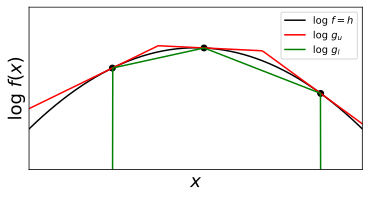

In [226]:
# The log unnormalised density to illustrate
log_prob = log_gaussian(0., 1.)

# Points in the abcissa set and corresponding log-probabilities and gradients
xs = np.array([-1., 0.1, 1.5])
hs, dhdxs = log_prob(xs)

# Locations to plot the log unnorm. density and envelope/squeezing functions
x_plot = np.linspace(-2, 2, 200)
log_probs = [log_prob(x)[0] for x in x_plot]
gu = [g_u(x, xs, hs, dhdxs) for x in x_plot]
gl = [g_l(x, xs, hs) for x in x_plot]

# Plot the log unnormalised density, the envelope and squeezing functions
plt.figure(figsize=(6, 3))
plt.scatter(xs, hs, color='k', zorder=2)
plt.plot(x_plot, log_probs, color='black', label='$\log~f = h$')
plt.plot(x_plot, np.log(gu), color='red', label='$\log~g_u$')

# Handle the case of negatively infinite gl, for plotting presentation
floored_log_gl = np.log(np.maximum(np.array(gl), np.ones_like(gl) * 1e-9))
plt.plot(x_plot, floored_log_gl, color='green', label='$\log~g_l$')

# Plot formatting
plt.xlim([-2, 2])
plt.ylim([-3, 1])
plt.xticks([])
plt.yticks([])
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$\log~f(x)$', fontsize=18)
plt.legend()
plt.show()

## Adaptive rejection sampling

As observed above, by vitrue of the log-concavity of $f$, the envelope and squeezing functions defined in this way are upper and lower bounds to $f$. If we then sample a point at random from the area under $g_u$, and this point also happens to be in the area under $f$, then the point is uniformly distributed in the area under $f$, and is an exact sample from the target distribution. Further, if the point happened to lie in the area under the squeezing function $g_l$, it is certain to also lie in the area under $f$, so we need not check this latter condition explicitly. This shortcut is particularly useful if the function $f$ is expensive to evaluate, because it avoids some of the evaluations of $f$. Combining these checks, we arrive at the ARS algorithm below.

<div class="definition">
    
**Algorithm (Adaptive Rejection Sampling)** Given a univariate un-normalised probability density $f(x)$, perform the following initialisation, sampling and update steps:
    
1. Initialise an abscissa set $T_k$, such that $f'(x_1) > 0$ and $f'(x_k) < 0$, as well as the corresponding envelope and squeezing functions $g_u$ and $g_l$. This can be efficiently achieved by starting from an initial guess and stepping out in steps of exponentially increasing size.
2. Sample \\[x' \sim \frac{g_u(x)}{\int g_u(x') dx'} \text{ and } z \sim \text{Unifrom}(0, 1),\\] and perform the following squeezing and rejection tests. If \\[z \leq \frac{g_l(x')}{g_u(x')}\\] holds, then accept $x'$ otherwise perform the following rejection test \\[z \leq \frac{h(x')}{g_u(x')}\\] If this holds, accept the point and otherwise reject it.
3. If $x'$ was accepted at the squeezing test, go to step 2 immediately. Otherwise insert $x'$ into $T_k$ to obtain $T_{k+1}$, update the piecewise exponential functions $g_l$ and $g_u$ accordingly and then return to step 2.
    
</div>
<br>

Below are functions which implement envelope sampling, that is drawing 

$$ x' \sim \frac{g_u(x)}{\int g_u(x') dx'}. $$

The first function determines the left and right limits as well as the the unnormalised probabilities $\int g_{u, k}(x') dx'$ of each piecewise exponential. The second samples uniformly from the area under the envelope function $g_u$.

In [229]:
def envelope_limits_and_unnormalised_probabilities(xs, hs, dhdxs):
    
    # Compute the points of intersection of the lines making up the envelope
    z, c = compute_intercepts_and_points_of_intersection(xs, hs, dhdxs)
    
    # Left-right endpoints for each piece in the piecewise envelope
    limits = np.concatenate([[float('-inf')], z, [float('inf')]])
    limits = np.stack([limits[:-1], limits[1:]], axis=-1)
    
    probs = 1 / dhdxs * (np.exp(dhdxs * limits[:, 1]) \
                         - np.exp(dhdxs * limits[:, 0])) * np.exp(c)
    
    return limits, probs


def sample_envelope(xs, hs, dhdxs):
    
    limits, probs = envelope_limits_and_unnormalised_probabilities(xs, hs, dhdxs)
    probs = probs / np.sum(probs)
    
    # Randomly chosen interval in which the sample lies
    i = np.random.choice(np.arange(probs.shape[0]), p=probs)
    
    # Sample u = Uniform(0, 1)
    u = np.random.uniform()
    
    # Invert i^th piecewise exponential CDF to get a sample from that interval
    x = np.log(u * np.exp(dhdxs[i] * limits[i, 1]) \
               + (1 - u) * np.exp(dhdxs[i] * limits[i, 0]))
    x = x * dhdxs[i] ** -1 
    
    return x

If we draw samples from the envelope defined by the three previous points without the rejection step, we obtain the following distribution.

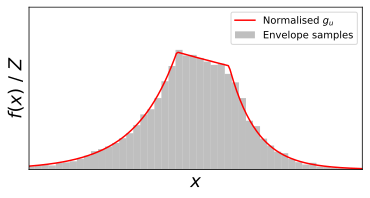

In [230]:
x_plot = np.linspace(-4., 4., 200)
_, probs = envelope_limits_and_unnormalised_probabilities(xs, hs, dhdxs)

samples = [sample_envelope(xs, hs, dhdxs) for i in range(10000)]
gu = [g_u(x, xs, hs, dhdxs) / np.sum(probs) for x in x_plot]

# Plot samples and envelope
plt.figure(figsize=(6, 3))
plt.plot(x_plot,
         gu,
         color='red',
         label='Normalised $g_u$')

plt.hist(samples,
         density=True,
         bins=100,
         color='gray',
         alpha=0.5,
         label='Envelope samples')

# Plot formatting
plt.title('', fontsize=20)
plt.xlim([-4, 4])
plt.ylim([0, 0.5])
plt.xticks([])
plt.yticks([])
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$f(x)~/~Z$', fontsize=18)
plt.legend()
plt.show()

We still need to add the initialisation of the abcissa set, the (optional) squeezing test and the rejection test. For the initialisation step, we can start from an initial point, and search to the left and to the right in exponentially increasing step sizes, until we find a point on the left side with positive $h'$ and a point on the right with negative $h'$, and use these as end-points of the abscissa set. The following function `adaptive_rejection_sampling` implements this initialisation step together with the squeezing and rejection tests.

## References

```{bibliography} ./ars.bib
```